In [293]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
import time

In [46]:
# Simulation Parameters
length = 10 # Meters
resolution = 1000

# Firefly Parameters
vision_length = 3 #meters
vision_cone = 40 #degrees

In [280]:
class swarm:
    def __init__(self, n, spread, attraction, repulsion, randomness, sim_frames = 100):
        self.fireflies = []
        self.N = n
        self.c1 = attraction  # Attraction Scaling factor
        self.c2 = repulsion   # Repulsion scaling factor
        self.c3 = randomness  # Randomness scaling factor

        self.rep_radius = 1   # Radius of repulsion effect

        self.frames = sim_frames  # No. of frames
        self.delta = 1            # Scaling of frames

        self.pspread = spread  # Spread of initial positions (gaussian)
        self.vspread = 2  # Spread of initial velocitys (gaussian)

        # initiaized below
        self.p = None
        self.v = None
        self.o = None

    def initialize(self):
        # positions
        self.p = np.random.normal(loc=10, scale=self.pspread, size=(3, self.N))
        # velocities
        self.v = self.vspread*np.random.randn(3, self.N)
        self.v = self.v / np.linalg.norm(self.v, axis=0)
        #self.fig = plt.figure()
        #self.ax = self.fig.add_subplot(111)

    def __repr__(self):
        return self.p
    
    def graph(self):
        x = self.p[0,:]
        y = self.p[1,:]
        z = self.p[2,:]

        fig = plt.figure(figsize = (10, 7))
        ax = plt.axes(projection ="3d")
    
        # Creating plot
        ax.scatter3D(x,y,z, color = "green")
        plt.title("Fireflies in Space")

        ax.set_xlim3d(0,20)
        ax.set_ylim3d(0,20)
        ax.set_zlim3d(0,20)

    def ff_in_vision(self, n, graph = False):
        ## KURT ##
        ## For now, develop this method that will return the indexes of fireflies
        ## in the visual range of firefly index n. i.e. self.p[:,n]
        ## you'll need to determine the orientation of the firefliy with the
        ## 3D velocity vectors in self.v[:,n], and then extend out a 3D cone
        ## with some arbitrary parameters (I'm thinking h = 1m, r = .3m?)
        ## reuturn all indicies for fireflies that fall within that cone
        ## try to make it computationally efficient.
        ## https://stackoverflow.com/questions/12826117/how-can-i-detect-if-a-point-is-inside-a-cone-or-not-in-3d-space
        ## https://math.stackexchange.com/questions/3130813/rotating-a-vector-perpendicular-to-another
        ## https://mathinsight.org/dot_product
        
        # vision_length = vector length
        cone_t = self.p[:,n]   # cone position at tip
        cone_d = vision_cone   # cone degrees
        cone_l = vision_length # cone length
        cone_v = self.v[:,n]   # cone normalized direction vector
        
        ff_detected = []  # index of fireflies that are detected
        for i in range(self.N):
            pt = self.p[:,i]

            # project point onto axis of cone
            cone_dist = np.dot(pt - cone_t, cone_v)
            if cone_dist > 0 and cone_dist <= cone_l:

                # find angle between (pt-cont_t) vector and cone_v vector
                theta = np.arccos(cone_dist / np.linalg.norm(pt - cone_t)) * 180/np.pi
                if theta < cone_d:
                    ff_detected.append(i)

        if graph == False:
            return ff_detected

        ### PLOTTING CONE AND DETECTED FIREFLIES ###
        vision_end = self.p[:,n] + cone_l * self.v[:,n]
        cone_Br = cone_l * np.tan(cone_d * np.pi/180) # cone base radius
        
        ## Create 2 perpendicular vectors based on velocity
        # 1st vector
        v1 = self.v[:,n] 
        # 2nd vector
        v2 = np.random.randn(3)      # take a random vector
        v2 -= v2.dot(v1) * v1        # make it orthogonal to vel
        v2 /= np.linalg.norm(v2)     # normalize it
        # 3rd vector
        v3 = np.cross(v1, v2)

        # rotated vectors
        vr = [np.cos(i) * v2 + np.sin(i) * v3 for i in range(90)]
        
        # mark non-detected fireflies green
        Fn = [i for i in range(self.N) if i not in ff_detected and i != n]
        xa = self.p[0,Fn]
        ya = self.p[1,Fn]
        za = self.p[2,Fn]
        
        # mark base firefly blue
        x0 = self.p[0,n]
        y0 = self.p[1,n]
        z0 = self.p[2,n]
        
        # mark detected fireflies red
        x1 = self.p[0,ff_detected]
        y1 = self.p[1,ff_detected]
        z1 = self.p[2,ff_detected]
        
        # mark line of sight of base firefly
        x2 = np.linspace(x0, vision_end[0], 10)
        y2 = np.linspace(y0, vision_end[1], 10)
        z2 = np.linspace(z0, vision_end[2], 10)
        
        fig = plt.figure(figsize = (10, 7))
        ax = plt.axes(projection ="3d")
    
        # Creating plot
        ax.scatter3D(xa,ya,za, color = "green")  # non_detected fireflies
        ax.scatter3D(x1,y1,z1, color = "red")    # detected fireflies
        ax.scatter3D(x0,y0,z0, color = "blue")   # base firefly
        
        # plot axis of sight
        ax.plot(x2,y2,z2, color = "gray")  # vision vector
        
        # make cone for sight of firefly
        for rad in vr:
            # make base of cone
            xr = np.linspace(vision_end[0]-cone_Br*rad[0], vision_end[0]+cone_Br*rad[0], 10)
            yr = np.linspace(vision_end[1]-cone_Br*rad[1], vision_end[1]+cone_Br*rad[1], 10)
            zr = np.linspace(vision_end[2]-cone_Br*rad[2], vision_end[2]+cone_Br*rad[2], 10)
            ax.plot(xr,yr,zr, color="gray")

            # make edges of cone
            ax.plot(np.linspace(x0, xr[0], 10), np.linspace(y0, yr[0], 10), np.linspace(z0, zr[0], 10), color = "gray")
            ax.plot(np.linspace(x0, xr[-1], 10), np.linspace(y0, yr[-1], 10), np.linspace(z0, zr[-1], 10), color = "gray")

        plt.title("Detected Fireflies")

        ax.set_xlim3d(0,20)
        ax.set_ylim3d(0,20)
        ax.set_zlim3d(0,20)

    def center_mass(self):  # Calculate center of gravity of all fireflies
        pos_sums = 0
        for i in range(self.N):
            pos_sums += self.p[:,i]
        com = pos_sums / self.N
        return( com.reshape((3,1)) )
    
    def simulate(self, graph = False):    # Simulate firefly swarm
        for _ in range(self.frames): # Iterate through all frames
            # Attraction to center of gravity
            center = self.center_mass()
            attraction = center - self.p

            # Randomness
            randomness = np.random.normal(loc=0, scale=1, size=(3, self.N))

            # Pre-allocate repulsion vector
            repulsion = np.zeros((3, self.N))

            for i in range(self.N):
                ## Find all fireflies within range of ith 
                temp = np.delete(self.v, i, axis=1)

                # Selct all columns where euclidean distance is less than the rep_radius
                distance = np.linalg.norm(temp - self.v[:,i].reshape(3,1), axis = 0)

                # If there are no nearby fireflies, skip
                if distance.shape[0] == 0:
                    continue  
                # select vector columns & distances that meet distance criteria
                slices = temp[:, np.where(distance < self.rep_radius)[0]]
                distance_slice = distance[np.where(distance < self.rep_radius)]
                # Scale slices by inverse of distance (farther away = less strong effect)
                slices *= (1/distance_slice)  # Scale slices by distance
                # Find the average repulsion 
                repulsion[:,i] = np.mean(self.v[:,i].reshape(3,1) - slices, axis = 1).reshape(3,)
            # Normalize all vectors
            attraction = attraction / np.linalg.norm(attraction, axis=0)
            repulsion = repulsion / np.linalg.norm(repulsion, axis=0)
            randomness = randomness / np.linalg.norm(randomness, axis=0)
            # Update velocities
            self.v = self.v + self.c1*attraction + self.c2*repulsion + self.c3*randomness
            # Update positions
            self.p = self.p + self.v * self.delta
            # Graph
            if graph == True:
                self.graph()

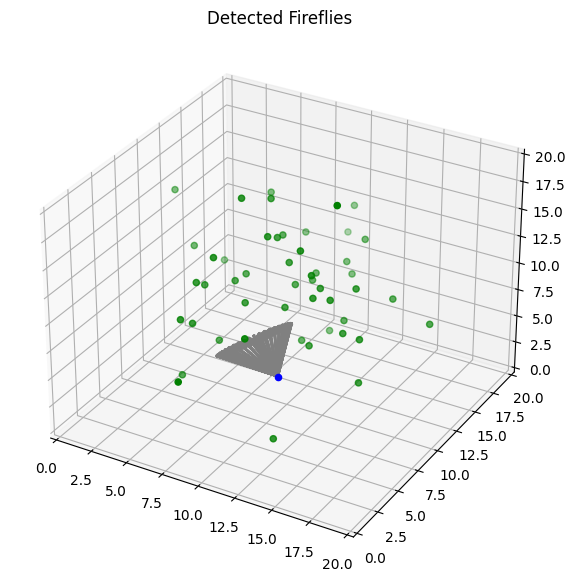

In [300]:
n_agents = 50
c1 = 0.1    # attraction
c2 = 0.001  # repulsion
c3 = 0.01   # randomness
c4 = 3.5    # positional spread (gaussian standard deviation)

fireflies = swarm(n = n_agents, spread = c4, attraction = c1, repulsion = c2, randomness = c3)
fireflies.initialize()
fireflies.ff_in_vision(3, graph = True)

#fireflies.simulate()

In [275]:
fireflies.ff_in_vision(3)